In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2 
import keras
from keras.preprocessing import image
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets, layers, models
from sklearn.metrics import log_loss, accuracy_score
from sklearn.linear_model import LogisticRegression
from keras_preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from tensorflow.keras import backend as K
from keras.applications import xception
from keras.applications.resnet50 import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Softmax
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from keras.applications.vgg16 import VGG16


# Prepping Data

In [3]:
# df = pd.DataFrame(sorted(glob.glob('/Users/anishamalhotra/Desktop/Images/*/*')), columns = ['path'])
# len(df)

20580

In [4]:
# df['labels'] = df['path'].apply(lambda x: x.split('/')[-2].split('-',1)[1])
# df.head()

,path,labels
0,/Users/anishamalhotra/Desktop/Images/n02085620...,Chihuahua
1,/Users/anishamalhotra/Desktop/Images/n02085620...,Chihuahua
2,/Users/anishamalhotra/Desktop/Images/n02085620...,Chihuahua
3,/Users/anishamalhotra/Desktop/Images/n02085620...,Chihuahua
4,/Users/anishamalhotra/Desktop/Images/n02085620...,Chihuahua


In [48]:
# df.to_csv('images.csv', index = False)
# https://keras.io/api/preprocessing/image/

In [130]:
# # images = []

# # for i in df[0]['path']:
# image = tf.keras.preprocessing.image.load_img(df.iloc[0]['path'])
# input_arr = keras.preprocessing.image.img_to_array(image)
# input_arr = np.array([input_arr])


In [3]:
batch_size = 32
img_height = 256
img_width = 256
data_dir='/Users/anishamalhotra/Desktop/Images'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 16464 files for training.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [7]:
images = np.zeros((32,256,256,3))
labels = np.zeros((32,))
for image, label in train_ds:
    images = image
    labels = label
    print(image.shape)
    print(label.shape)
    break

(32, 256, 256, 3)
(32,)


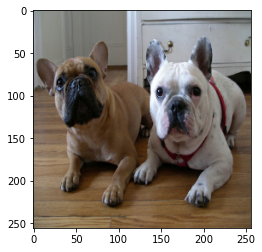

In [7]:
plt.imshow(images[0]/255.)

In [27]:
class_names = train_ds.class_names
class_names

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

# EDA

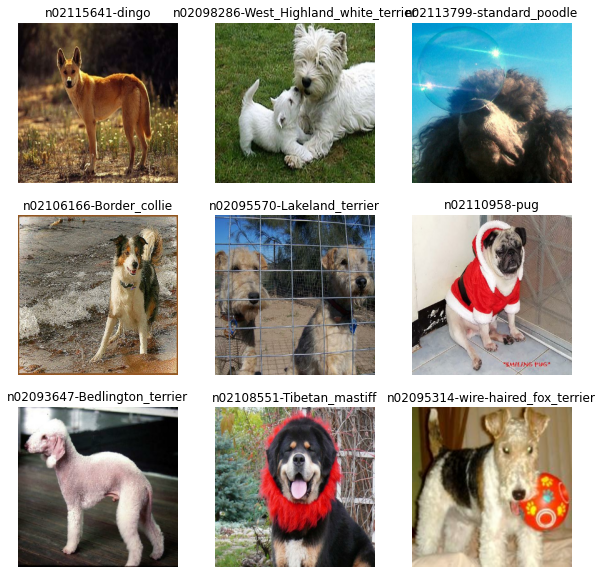

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [36]:
breeds = df['labels'].value_counts()
ax, fig = plt.subplots(figsize = (40,20))
plt.bar(breeds.index, breeds.values, color = 'salmon')
plt.xticks(breeds.index, rotation=90, fontsize=20)
plt.title('Image Count per Breed', fontsize = 30)
plt.yticks(fontsize = 20)

plt.savefig('imagecount.png')

NameError: name 'df' is not defined

# Scaling

In [15]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, 
                                   zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(data_dir, target_size=(256, 256),
                                                    batch_size=32)
test_generator = test_datagen.flow_from_directory(data_dir, target_size=(256, 256),
                                                        batch_size=32)

Found 20580 images belonging to 120 classes.
Found 20580 images belonging to 120 classes.


In [10]:
for image_batch, labels_batch in train_generator:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 256, 256, 3)
(32, 120)


# Modeling

## resnet

In [31]:
inputs = keras.Input(shape=(256, 256, 3))

resnet = ResNet50(
    input_shape= (256,256,3),
    include_top=False,
    weights='imagenet')

resnet.trainable = False

x = resnet.output
x = keras.layers.Flatten()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.4)(x)
x = keras.layers.Dense(2048, activation='relu')(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(120, activation='softmax')(x)

model_resnet = keras.Model(resnet.input, outputs)

for layer in resnet.layers:
    layer.trainable = False


In [32]:
model_resnet.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])


In [35]:
model_resnet.fit(
        train_generator,
        epochs=3,
        validation_data=test_generator)

Epoch 1/3
 14/644 [..............................] - ETA: 1:30:56 - loss: 6.3178 - accuracy: 0.0134

KeyboardInterrupt: 

# m5

In [25]:

model_RN50 = ResNet50(
    input_shape= (256,256,3),
    include_top=False,
    weights='imagenet')

In [26]:
model_RN50.trainable = False

In [124]:
model_RN50.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [27]:
model_transfer = tf.keras.Sequential(
     [model_RN50, 
#         tf.keras.layers.Conv2D(2048, 1024),
     tf.keras.layers.Flatten(), tf.keras.layers.Dense(120, activation='softmax')])



In [28]:
[layer.trainable for layer in model_transfer.layers]

[False, True, True]

In [29]:
model_transfer.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])


In [30]:
model_transfer.fit(train_generator,
        epochs=3,
        validation_data=test_generator)

Epoch 1/3
644/644 [==============================] - 9839s 15s/step - loss: 35.0300 - accuracy: 0.0158 - val_loss: 32.9230 - val_accuracy: 0.0200
Epoch 2/3
644/644 [==============================] - 11312s 18s/step - loss: 29.3701 - accuracy: 0.0248 - val_loss: 21.7867 - val_accuracy: 0.0483
Epoch 3/3
644/644 [==============================] - 6384s 10s/step - loss: 27.9443 - accuracy: 0.0325 - val_loss: 28.9445 - val_accuracy: 0.0395


In [35]:
# keras.models.save_model(model,'mask_model.h5')

# Preds

In [ ]:
def get_threshold(image) :
    a,b,x=plt.hist(image.flatten())
    arg=np.argmax(a)
    threshold=[b[arg],b[arg+1]]
    plt.clf()
    return threshold
def make_mask(path,color='blue',print_plot=False):
    image=Image.open(path)
    image=image.resize((150,150))
    image=image.convert('L')
    image=np.array(image)
    threshold=get_threshold(image)
    if color=='blue' :
        n=[0,0,255]
    masked_image=[]
    for i in image.flatten() :
        if i >= threshold[0] and i<=threshold[1] :
            masked_image.append(255)
        else:
            masked_image.append(0)
    masked_image=np.array(masked_image)
    masked_image=masked_image.reshape(image.shape)
    if print_plot==True :
        plt.imshow(masked_image)
    return masked_image

In [ ]:
def make_predictions(path) :
    l=['Cats','Dogs']
    print('The masked image is :')
    arr=make_mask(path,print_plot=True)
    arr=np.array(arr)
    arr=arr.reshape(1,150,150)
    clas=np.argmax(model.predict(arr),axis=-1)
    print(l[clas[0]])

# Transfer w TF Hub

In [18]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

In [20]:

classifier = tf.keras.Sequential([
    hub.KerasLayer(model_2lr, input_shape=(256,256,3))
])

In [21]:
result_batch = classifier.predict(train_ds)

In [29]:
predicted_class_names = labels_batch[np.argmax(result_batch, axis=-1)]
predicted_class_names

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/matplotlib/text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


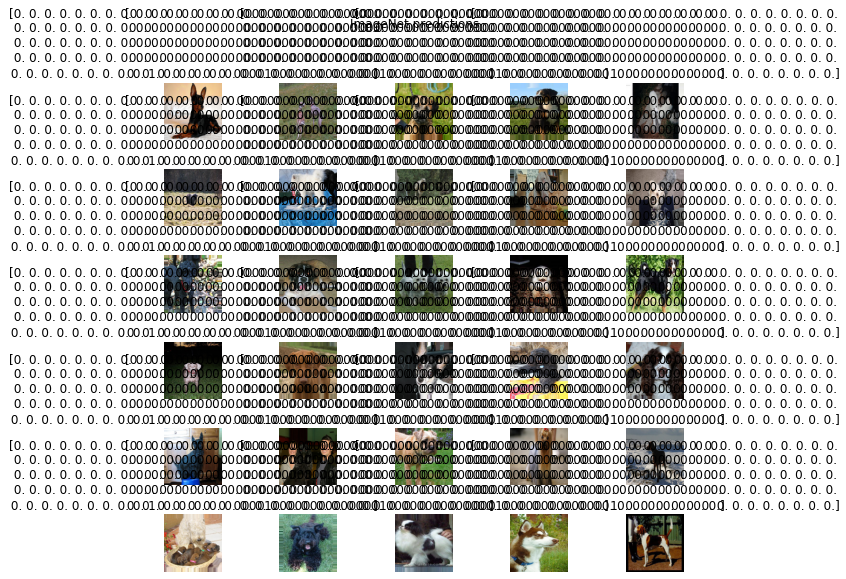

In [25]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# VGGG

In [22]:
# define a new model with random weights and 10 classes
model_VGG = VGG16(weights='imagenet'
#                  ,include_top=False, 
#                   input_shape=(256,256,3), classes=1000
                 )

model_VGG.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
model_VGG.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [24]:
model_VGG.fit(
        train_generator,
        epochs=3,
        validation_data=test_generator)

Epoch 1/3


InvalidArgumentError:  Input to reshape is a tensor with 1048576 values, but the requested shape requires a multiple of 25088
	 [[node vgg16/flatten/Reshape (defined at <ipython-input-24-0570deb8be22>:1) ]] [Op:__inference_train_function_5149]

Function call stack:
train_function


In [37]:
VGG = VGG16(weights='imagenet',
                  include_top=False, 
                  input_shape=(256,256,3))

VGG.trainable = False

z = VGG.output
z = keras.layers.Flatten()(z)
z = keras.layers.Dropout(0.4)(z)
z = keras.layers.Dense(2048, activation='relu')(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dropout(0.4)(z)
z = keras.layers.Dense(2048, activation='relu')(z)
z = keras.layers.BatchNormalization()(z)
z = keras.layers.Dropout(0.2)(z)
outputs = keras.layers.Dense(120, activation='softmax')(z)

model_VGG = keras.Model(VGG.input, outputs)

for layer in VGG.layers:
    layer.trainable = False

In [38]:
model_VGG.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [39]:
history_VGG = model_VGG.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator)

Epoch 1/10
 38/644 [>.............................] - ETA: 2:18:37 - loss: 6.1876 - accuracy: 0.0197

KeyboardInterrupt: 

# h

In [ ]:

# example of loading the inception v3 model
from keras.applications.inception_v3 import InceptionV3
# load model
model = InceptionV3()
# summarize the model
model.summary()

In [ ]:
eval_df = pd.DataFrame({
    'model_1': '2.30%',
    'model_2': '32.22%',
    'inception_model': '91.97%',
    'resnet_model': '8.29%',
}, index=['Accuracy Score'])

In [ ]:

# example of loading the resnet50 model
from keras.applications.resnet50 import ResNet50
# load model
model = ResNet50()
# summarize the model
model.summary()

# idk

In [ ]:
model_2h = Sequential()
model_2h.add(Dense(1000, activation = 'tanh', input_shape = (256,256,3)))
model_2h.add(Flatten())
model_2h.add(Dropout(0.25))
model_2h.add(Dense(750, activation = 'relu'))
model_2h.add(Dense(500, activation = 'tanh'))
model_2h.add(Dropout(0.25))
model_2h.add(Dense(240, activation = 'relu'))
model_2h.add(Dense(120, kernel_regularizer=regularizers.l2(0.01), activation = 'softmax'))
model_2h.summary()

In [ ]:
model_2h.compile(loss='categorical_crossentropy',
              optimizer = 'adam',
              metrics=['accuracy'])

In [ ]:
model_2h.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator)